# Exploring the demonstration models

This notebook shows several standard ways to interact with the demonstrations stored into the exp/run directories. 

In [ ]:
import sys
sys.path.append("..")
from exp_run_config import Config
Config.PROJECTNAME = "BerryPicker"

import cv2

import matplotlib.pyplot as plt
import random
import torch
import json

import pathlib
from demonstration import Demonstration, list_demos, select_demo

In [3]:
experiment = "demonstration"
run = "freeform"

exp = Config().get_experiment(experiment, run)

***ExpRun**: Loading pointer config file:
	C:\Users\lboloni\.config\BerryPicker\mainsettings.yaml
***ExpRun**: Loading machine-specific config file:
	G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\settings-LotziYoga.yaml
***ExpRun**: Experiment default config C:\Users\lboloni\Documents\Code\_Checkouts\BerryPicker\src\experiment_configs\demonstration\_demonstration.yaml was empty, ok.
***ExpRun**: No system dependent experiment file
	 G:\My Drive\LotziStudy\Code\PackageTracking\BerryPicker\settings\experiment-config\LotziYoga\demonstration\freeform_sysdep.yaml,
	 that is ok, proceeding.
***ExpRun**: Configuration for exp/run: demonstration/freeform successfully loaded


### Read out all the demonstrations from a run

In [4]:
# read out all the demonstrations from a run
#demos = [item.name for item in exp.data_dir().iterdir() if item.is_dir()]
demos = list_demos(exp)
print(demos)

['2024_12_26__16_40_20', '2024_12_26__16_44_06', 'testing']


In [9]:
demo = select_demo(exp)

A pop up dialog will appear now. Enter the number of demonstration.
	0: 2024_12_26__16_40_20
	1: 2024_12_26__16_44_06
	2: testing
You chose demonstration: testing


###  Read out all the pictures in the demonstration

FIXME: I had redone this from scratch, but should have used the demonstration_helper and there was something called analyze demo...

Put them together. All these functions should take the experiment. 

{'cameras': ['dev2'],
 'demo': 'testing',
 'demo_dir': WindowsPath('c:/Users/lboloni/Documents/Code/_TempData/BerryPicker-experiments/demonstration/freeform/testing'),
 'exp': Experiment: {'experiment_name': 'demonstration', 'name': 'freeform', 'run_name': 'freeform', 'exp_run_sys_indep_file': 'C:\\Users\\lboloni\\Documents\\Code\\_Checkouts\\BerryPicker\\src\\experiment_configs\\demonstration\\freeform.yaml', 'data_dir': 'c:\\Users\\lboloni\\Documents\\Code\\_TempData\\BerryPicker-experiments\\demonstration\\freeform', 'subrun_name': None, 'time_started': '2025-05-12 14:29:20'},
 'maxsteps': 596}
Cameras found: ['dev2']
There are 596 steps in this demonstration
This demonstration was recorded by the following cameras: ['dev2']


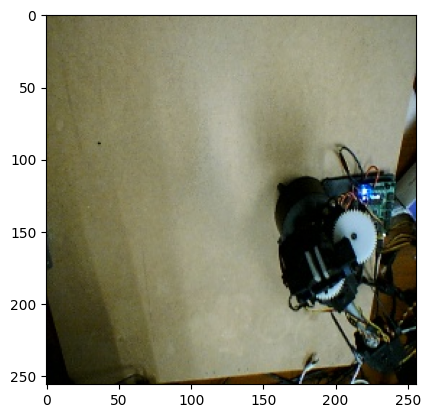

In [11]:
demo = Demonstration(exp, demo)
print(demo)
print(f"Cameras found: {demo.cameras}")
print(f"There are {demo.maxsteps} steps in this demonstration")
print(f"This demonstration was recorded by the following cameras: {demo.cameras}")

# pick and show a random image from a random camera
cam = random.choice(demo.cameras)
imgno = random.randint(0, demo.maxsteps)
sensor_readings, image = demo.get_image(imgno, camera=cam)

fig, ax = plt.subplots()
ax.imshow(image)


# Move all the figures to a video

In [ ]:
cam = demo.cameras[0]
video_path = pathlib.Path(demo.demo_dir, f"video_{cam}.mp4")

In [ ]:

def move_to_video():
    fps = 10
    width = 256
    height = 256

    # Initialize video writer

    if not video_path.exists():

        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))

        for i in range(demo.maxsteps):
            img_path = demo.get_image_path(i, camera=cam)
            frame = cv2.imread(str(img_path))
            out.write(frame)

        out.release()


In [ ]:
from sensorprocessing.sp_helper import load_capture_to_tensor

imgno = random.randint(0, demo.maxsteps)

cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, imgno)
ret, frame = cap.read()
if ret:
    # CV2 reads by default in BGR... 
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    # cv2.imwrite(output_image, frame)    
    image_to_process, image_to_show = load_capture_to_tensor(frame, transform=None)
else:
    print(f"Could not read frame {imgno}")
cap.release()

In [ ]:
sensor_readings, image = demo.get_image(imgno, camera=cam)

fig, [ax1, ax2, ax3] = plt.subplots(1,3)
ax1.imshow(image)
ax3.imshow(frame)
ax2.imshow(image_to_show)


In [ ]:
# print(sensor_readings == image_to_process)
# print(sensor_readings == sensor_readings)
a = image_to_process
b = sensor_readings
print(torch.allclose(image_to_process.float(), sensor_readings.float(), atol=0.5))

In [ ]:
a.shape
a[0][2][100][:]

In [ ]:
b.shape
b[0][2][100][:]

In [ ]:
a-b